In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import xgboost as xgb

from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso
from math import sqrt

In [16]:
## Load the data ##
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [17]:
TARGET = 'SalePrice'
ntrain = train.shape[0]
ntest = test.shape[0]

In [ ]:
## Preprocessing ## 
y_train = np.log(train[TARGET]+1)

train.drop([TARGET], axis=1, inplace=True)


all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:

x_train = np.array(all_data[:train.shape[0]])
x_test = np.array(all_data[train.shape[0]:])

kf = KFold(ntrain, n_folds=5, shuffle=True, random_state=SEED)

In [18]:
## Define Wrapper Class ##
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)


class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))


def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


In [ ]:
#define paramters
et_params = {
    'n_jobs': 16,
    'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 100,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'rmse',
    'nrounds': 500
}

rd_params={
    'alpha': 10
}

ls_params={
    'alpha': 0.005
}

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings('ignore')

from subprocess import check_output

train = pd.read_csv('input/train.csv')
labels=train["SalePrice"]
test = pd.read_csv('input/test.csv')
data = pd.concat([train,test],ignore_index=True)
data = data.drop("SalePrice", 1)
ids = test["Id"]

train.head()
train.shape[0]


# Count the number of rows in total
data.shape[0]

# Count the number of NaNs each column has.
nans=pd.isnull(data).sum()
nans[nans>0]

# Remove id and columns with more than a thousand missing values
data=data.drop("Id", 1)
data=data.drop("Alley", 1)
data=data.drop("Fence", 1)
data=data.drop("MiscFeature", 1)
data=data.drop("PoolQC", 1)
data=data.drop("FireplaceQu", 1)

# Count the column types
data.dtypes.value_counts()

all_columns = data.columns.values
non_categorical = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", 
                   "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
                   "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", 
                   "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
                   "ScreenPorch","PoolArea", "MiscVal"]

categorical = [value for value in all_columns if value not in non_categorical]

# One Hot Encoding and nan transformation
data = pd.get_dummies(data)

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
data = imp.fit_transform(data)

# Log transformation
data = np.log(data)
labels = np.log(labels)

# Change -inf to 0 again
data[data==-np.inf]=0

pca = PCA(whiten=True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

pca = PCA(n_components=36,whiten=True)
pca = pca.fit(data)
dataPCA = pca.transform(data)


# Split traing and test
train = dataPCA[:1460]
test = dataPCA[1460:]

cv = KFold(n_splits=5,shuffle=True,random_state=45)

parameters = {'alpha': [1000,100,10],
              'epsilon' : [1.2,1.25,1.50],
              'tol' : [1e-10]}

clf = linear_model.HuberRegressor()
r2 = make_scorer(r2_score)
grid_obj = GridSearchCV(clf, parameters, cv=cv,scoring=r2)
grid_fit = grid_obj.fit(train, labels)
best_clf = grid_fit.best_estimator_ 

best_clf.fit(train,labels)

predictions_huber = best_clf.predict(test)
predictions_huber = np.exp(predictions_huber)
sub = pd.DataFrame({
        "Id": ids,
        "SalePrice": predictions_huber
    })
sub.to_csv("prices_submission_huber.csv", index=False)

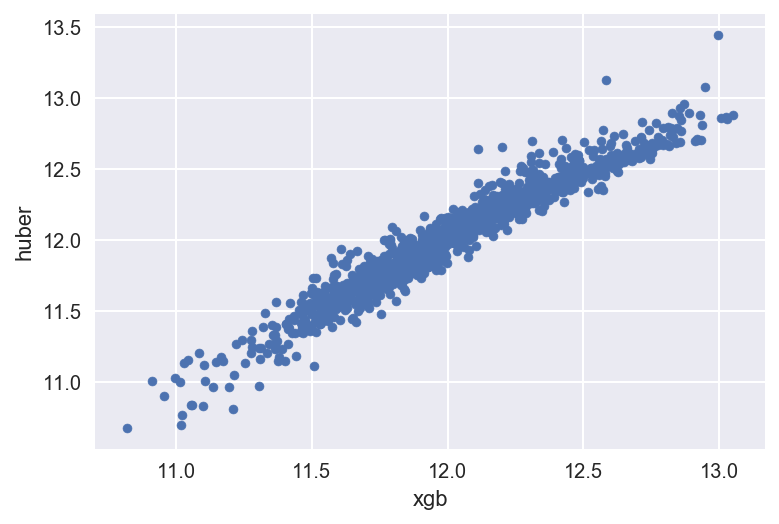

In [29]:
import xgboost as xgb

regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train, labels)


y_pred_xgb = regr.predict(test)
predictions_huber = best_clf.predict(test)

predictions = pd.DataFrame({"xgb":y_pred_xgb, "huber":predictions_huber})
predictions.plot(x = "xgb", y = "huber", kind = "scatter")



In [31]:
preds = 0.7*predictions_huber + 0.3*y_pred_xgb
solution = pd.DataFrame({"id": ids, "SalePrice":preds})
solution.to_csv("weightedxgbhuber_sol.csv", index = False)